AirQo African Air Quality Prediction aims to predict air quality around Africa using Sentinel 5P satellite data.

The performance of the air quality prediction models will be evaluated using Root Mean Squared Error (RMSE), Mean Absolute Error (MAE) and R-squared

IMPORTING LIBRARIES AND DRIVE

In [ ]:
# Import libraries
!pip install seaborn
!pip install dask[dataframe]
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Import drive into google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


DATA INSPECTION

In [ ]:
# Load file
Air_qlt = pd.read_csv ('/content/drive/MyDrive/Colab Notebooks/Airquo.csv')

In [ ]:
# Setting column display above maximum limit
pd.set_option('display.max_columns',None)

In [ ]:
# Number of rows and columns in the data
Air_qlt.shape

(8071, 80)

In [ ]:
# Preview  of the first and last five rows of the data
Air_qlt

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
0,id_vjcx08sz91,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-10-25,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052301,828817.937500,-100.805145,21.720518,-123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,-100.805145,21.720518,-123.523796,33.745914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000
1,id_bkg215syli,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-11-02,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,0.045475,3771.027210,3399.756845,828569.623806,69.245351,59.159695,-143.370575,26.566997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000214,1.462390,0.000240,0.359150,26.525513,-143.480164,59.220097,70.875954,-0.315206,828578.625000,70.875954,59.220097,-143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,-143.480164,26.525513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200
2,id_oui2pot3qd,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-11-03,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.097816,828878.687500,-96.411942,61.045010,-121.307121,41.898113,0.117559,3.248703,0.384168,224.102463,0.754163,-96.411942,61.045010,-121.307121,41.898113,NaN,NaN,NaN,NaN,NaN

In [ ]:
# Displaying column names and datatypes
Air_qlt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8071 entries, 0 to 8070
Data columns (total 80 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   id                                                        8071 non-null   object 
 1   site_id                                                   8071 non-null   object 
 2   site_latitude                                             8071 non-null   float64
 3   site_longitude                                            8071 non-null   float64
 4   city                                                      8071 non-null   object 
 5   country                                                   8071 non-null   object 
 6   date                                                      8071 non-null   object 
 7   hour                                                      8071 non-null   int64  
 8   sulphurdioxide_so2

In [ ]:
Air_qlt[['city', 'country', 'hour']].nunique()

city       4
country    4
hour       5
dtype: int64

In [ ]:
Air_qlt['country'].unique()

array(['Nigeria', 'Kenya', 'Burundi', 'Uganda'], dtype=object)

In [ ]:
Air_qlt['city'].unique()

array(['Lagos', 'Nairobi', 'Bujumbura', 'Kampala'], dtype=object)

In [ ]:
Air_qlt['hour'].unique()

array([13, 12, 14, 10, 11])

• The dataset contains 8,071 rows and 80 columns. It is multi-dimensional dataset with numerous environmental variables.

•  The data covers 4 countries: Nigeria, Kenya, Burundi, and Uganda. It includes 4 cities: Lagos, Nairobi, Bujumbura, and Kampala. This indicates a focus on urban air quality in East and West Africa.

• Data is collected across 5 different hours of the day (10, 11, 12, 13, 14) for multiple months (a full year).

• PM2.5 is the main air quality indicator, with data for all 8,071 entries.

• Other pollutants measured include sulphur dioxide, carbon monoxide, nitrogen dioxide, formaldehyde, and ozone.

• Many columns have missing values (non-null counts less than 8,071).

• UV aerosol layer height has the least data (427 non-null values).

In [ ]:
# Descriptive statistics
Air_qlt.describe()

,site_latitude,site_longitude,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
count,8071.000000,8071.000000,8071.000000,3159.000000,3159.000000,3159.000000,3159.000000,3159.000000,3159.000000,3159.000000,3159.000000,3159.000000,8071.000000,4441.000000,4441.000000,4441.000000,4441.000000,4441.000000,4441.000000,4441.000000,4441.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,4156.000000,4156.000000,4156.000000,4156.000000,4156.000000,4156.000000,4156.000000,4156.000000,8066.000000,8066.000000,8066.000000,8066.000000,8066.000000,8066.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,8071.000000
mean,0.635678,30.246982,10.877463,0.000024,0.687295,0.000013,0.126581,2.120939,38.671939,-92.912582,27.700157,0.000004,6.122414,0.034887,2200.218221,2041.463881,829573.191993,-8.063021,38.482742,-91.507702,28.609344,0.000074,0.000040,0.000033,0.000130,8836.367723,-0.369219,0.081754,829581.679425,-12.334603,37.299477,-93.711870,28.807872,0.000175,1.046935,0.000109,0.192196,28.036877,-92.363482,40.218543,-2.760999,-0.442617,829596.648655,-12.608537,41.387619,-88.902996,28.385504,0.117739,2.650292,0.316414,228.241939,0.516471,-13.304661,41.293259,-88.650645,28.541850,2217.913597,78611.503814,1.880600,

 • The data covers a range of latitudes (from -3.46 to 6.59) and longitudes (from 3.20 to 36.91).

• PM2.5 levels have a wide range (1.2 to 456.19 μg/m³), with a mean of 24.64 μg/m³. This suggests periods of both good and very poor air quality. Other pollutants (SO2, CO, NO2, formaldehyde, ozone) show varying concentrations, with some having negative minimum values.

• Many parameters have means significantly different from their medians, indicating skewed distributions. This is especially notable for PM2.5 and some pollutant concentrations.

In [ ]:
# Checking for duplicates
Air_qlt.duplicated().sum()

0

In [ ]:
# Checking for missing values
Air_qlt.isnull().sum()

id                               0
site_id                          0
site_latitude                    0
site_longitude                   0
city                             0
                              ... 
cloud_sensor_azimuth_angle    3077
cloud_sensor_zenith_angle     3077
cloud_solar_azimuth_angle     3077
cloud_solar_zenith_angle      3077
pm2_5                            0
Length: 80, dtype: int64

In [ ]:
# Checking percentage of missing values
print(Air_qlt.isnull().sum()/ len(Air_qlt) *100)

id                             0.000000
site_id                        0.000000
site_latitude                  0.000000
site_longitude                 0.000000
city                           0.000000
                                ...    
cloud_sensor_azimuth_angle    38.124148
cloud_sensor_zenith_angle     38.124148
cloud_solar_azimuth_angle     38.124148
cloud_solar_zenith_angle      38.124148
pm2_5                          0.000000
Length: 80, dtype: float64


In [ ]:
# Showing columns with missing values >=50% and 70%
missing_50 = (Air_qlt.isnull().sum()/ len(Air_qlt)*100)[(Air_qlt.isnull().sum()/ len(Air_qlt)*100) >= 50]
missing_70 = (Air_qlt.isnull().sum()/ len(Air_qlt)*100)[(Air_qlt.isnull().sum()/ len(Air_qlt)*100) >= 70]

print("Columns with at least 50% missing values:\n", missing_50)
print("\nColumns with at least 70% missing values:\n", missing_70)

Columns with at least 50% missing values:
 sulphurdioxide_so2_column_number_density                   60.859869
sulphurdioxide_so2_column_number_density_amf               60.859869
sulphurdioxide_so2_slant_column_number_density             60.859869
sulphurdioxide_cloud_fraction                              60.859869
sulphurdioxide_sensor_azimuth_angle                        60.859869
sulphurdioxide_sensor_zenith_angle                         60.859869
sulphurdioxide_solar_azimuth_angle                         60.859869
sulphurdioxide_solar_zenith_angle                          60.859869
sulphurdioxide_so2_column_number_density_15km              60.859869
nitrogendioxide_no2_column_number_density                  61.541321
nitrogendioxide_tropospheric_no2_column_number_density     61.541321
nitrogendioxide_stratospheric_no2_column_number_density    61.541321
nitrogendioxide_no2_slant_column_number_density            61.541321
nitrogendioxide_tropopause_pressure                        6

• There are no duplicate rows in the dataset.

• Many variables have more than 50% missing values: All sulphur dioxide related variables (60.86% missing), all nitrogen dioxide related variables (61.54% missing) and UV aerosol layer height related variables (94.71% missing).

• Variables with more than 50% and  70% missing data will  be excluded from analysis and then split into two different variables.

DATA CLEANING

In [ ]:
# List of columns
print (Air_qlt.columns)

Index(['id', 'site_id', 'site_latitude', 'site_longitude', 'city', 'country',
       'date', 'hour', 'sulphurdioxide_so2_column_number_density',
       'sulphurdioxide_so2_column_number_density_amf',
       'sulphurdioxide_so2_slant_column_number_density',
       'sulphurdioxide_cloud_fraction', 'sulphurdioxide_sensor_azimuth_angle',
       'sulphurdioxide_sensor_zenith_angle',
       'sulphurdioxide_solar_azimuth_angle',
       'sulphurdioxide_solar_zenith_angle',
       'sulphurdioxide_so2_column_number_density_15km', 'month',
       'carbonmonoxide_co_column_number_density',
       'carbonmonoxide_h2o_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'carbonmonoxide_sensor_azimuth_angle',
       'carbonmonoxide_sensor_zenith_angle',
       'carbonmonoxide_solar_azimuth_angle',
       'carbonmonoxide_solar_zenith_angle',
       'nitrogendioxide_no2_column_number_density',
       'nitrogendioxide_tropospheric_no2_column_number_densi

In [ ]:
# Creating new variables based on percentage of missing values

# Dropping columns with missing values above 70%
# Creating new variable
columns_to_drop_70 = missing_70[missing_70 > 70].index
Air_qlt1 = Air_qlt.drop(columns=columns_to_drop_70)

# Dropping columns with missing values above 50%
# Creatig new variable
columns_to_drop_50 = missing_50[missing_50 > 50].index
Air_qlt2 = Air_qlt.drop(columns=columns_to_drop_50)

print(Air_qlt1.columns)
print(Air_qlt2.columns)

Index(['id', 'site_id', 'site_latitude', 'site_longitude', 'city', 'country',
       'date', 'hour', 'sulphurdioxide_so2_column_number_density',
       'sulphurdioxide_so2_column_number_density_amf',
       'sulphurdioxide_so2_slant_column_number_density',
       'sulphurdioxide_cloud_fraction', 'sulphurdioxide_sensor_azimuth_angle',
       'sulphurdioxide_sensor_zenith_angle',
       'sulphurdioxide_solar_azimuth_angle',
       'sulphurdioxide_solar_zenith_angle',
       'sulphurdioxide_so2_column_number_density_15km', 'month',
       'carbonmonoxide_co_column_number_density',
       'carbonmonoxide_h2o_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'carbonmonoxide_sensor_azimuth_angle',
       'carbonmonoxide_sensor_zenith_angle',
       'carbonmonoxide_solar_azimuth_angle',
       'carbonmonoxide_solar_zenith_angle',
       'nitrogendioxide_no2_column_number_density',
       'nitrogendioxide_tropospheric_no2_column_number_densi

In [ ]:
print(Air_qlt1.shape)
print(Air_qlt2.shape)

(8071, 73)
(8071, 52)


In [ ]:
# Replacing all empty spaces with NaN
Air_qlt1.replace('', np.nan, inplace=True)
Air_qlt2.replace('', np.nan, inplace=True)

In [ ]:
# Dropping missing values
Air_qlt1.dropna()

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
4,id_ali5x2m4iw,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-11-09,13,0.000267,0.774656,0.000207,0.223403,-97.811241,49.513344,-126.064468,40.167336,0.000083,11.0,0.049045,3514.042054,1678.370478,828902.790450,-96.099639,49.432796,-126.070747,40.144183,0.000097,0.000063,0.000035,0.000175,9582.712645,0.069667,0.142913,828919.000000,-97.811241,49.513344,-126.064468,40.167336,0.000100,1.298433,0.000068,0.223403,40.167336,-126.064468,49.513344,-97.811241,0.069669,828919.000000,-97.811241,49.513344,-126.064468,40.167336,0.117899,2.796072,0.334256,226.368851,0.226150,-97.811241,49.513344,-126.064468,40.167336,0.226141,86197.531250,1451.050659,96215.906250,451.050598,10.521009,0.153114,-97.811241,49.513439,-126.064453,40.167355,19.431731
9,id_02mf0t6b64,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-11-17,12,0.000114,0.595891,0.000068,0.075443,73.518127,38.779606,-142.403336,32.381630,0.000029,11.0,0.051003,2979.204248,1225.050212,828806.437312,71.570840,38.656195,-142.333301,32.405182,0.000141,0.000107,0.000034,0.000218,7311.869141,0.916821,0.096538,828813.937500,73.518127,38.779606,-142.403336,32.381630,0.000336,1.074984,0.000295,0.075443,32.381630,-142.403336,38.779606,73.518127,0.916824,828813.937500,73.518127,38.779606,-142.403336,32.381630,0.115559,2.511124,0.296154,233.882782,0.078534,73.518127,38.779606,-142.403336,32.381630,0.075157,63377.941406,4058.409668,71396.875000,3058.409668,4.432884,0.214505,73.518120,38.779526,-142.403320,32.381641,154.909800
19,id_l2z05k2vlo,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-12-10,13,0.000555,0.517860,0.000287,0.268258,-95.890935,65.307009,-131.510547,45.459401,0.000104,12.0,0.059561,4444.498535,3008.956299,829242.437500,-94.263290,65.3679

In [ ]:
# Dropping missing values
Air_qlt2.dropna()

,id,site_id,site_latitude,site_longitude,city,country,date,hour,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
4,id_ali5x2m4iw,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-11-09,13,11.0,0.049045,3514.042054,1678.370478,828902.790450,-96.099639,49.432796,-126.070747,40.144183,0.000100,1.298433,0.000068,0.223403,40.167336,-126.064468,49.513344,-97.811241,0.069669,828919.000000,-97.811241,49.513344,-126.064468,40.167336,0.117899,2.796072,0.334256,226.368851,0.226150,-97.811241,49.513344,-126.064468,40.167336,0.226141,86197.531250,1451.050659,96215.906250,451.050598,10.521009,0.153114,-97.811241,49.513439,-126.064453,40.167355,19.431731
9,id_02mf0t6b64,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-11-17,12,11.0,0.051003,2979.204248,1225.050212,828806.437312,71.570840,38.656195,-142.333301,32.405182,0.000336,1.074984,0.000295,0.075443,32.381630,-142.403336,38.779606,73.518127,0.916824,828813.937500,73.518127,38.779606,-142.403336,32.381630,0.115559,2.511124,0.296154,233.882782,0.078534,73.518127,38.779606,-142.403336,32.381630,0.075157,63377.941406,4058.409668,71396.875000,3058.409668,4.432884,0.214505,73.518120,38.779526,-142.403320,32.381641,154.909800
11,id_stc0uavy0y,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-11-23,12,11.0,0.046392,3539.902588,3955.364014,828805.750000,69.911583,54.143894,-148.957932,31.481571,0.000302,1.362197,0.000341,0.413242,31.501513,-148.929428,53.886005,71.619965,-0.243487,828815.000000,71.619965,53.886005,-148.929428,31.501513,0.113592,2.866768,0.331574,228.080780,0.415181,71.619965,53.886005,-148.929428,31.501513,0.415178,73086.281250,2889.231445,81258.609375,1889.231445,10.307960,0.128259,71.619957,53.885914,-148.929398,31.501530,21.050577
18,id_il4m9rsmpi,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-12-09,12,12.0,0.054174,2615.896973,953.316284,828974.625000,69.905113,54.145847,-153.587158,32.910831,0.000310,1.407577,0.000368,0.440821,32.863945,-153.658295,54.232574,71.571510,0.600129,828984.250000,71.578137,54.178097,-153.642388,32.874307,0.113008,2.884564,0.331596,230.421207,0.461598,71.578137,54.178097,-153.642388,32.874307,0.449181,79031.015625,2171.250977,88276.789063,1171.250977,9.900322,0.139710,71.571510,54.232479,-153.658264,32.863964,82.063000
19,id_l2z05k2vlo,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-12-10,13,12.0,0.059561,4444.498535,3008.956299,829242.437500,-94.263290,65.367950,-131.489853,45.456326,0.000472,0.728536,0.000285,0.268258,45.459401,-131.510547,65.307009,-95.890935,0.811503,829268.004065,-95.890935,65.307009,-131.510547,45.459401,0.114864,3.584543,0.412995,227.520580,0.269220,-95.890935,65.307009,-131.510547,45.4

In [ ]:
#Filling numeric missing data column average
fl = Air_qlt1.select_dtypes('float').columns.tolist()
for nw in fl:
    average = Air_qlt1[nw].mean()
    Air_qlt1[nw] = Air_qlt1[nw].fillna(average)

In [ ]:
#Filling numeric missing data column average
fl = Air_qlt2.select_dtypes('float').columns.tolist()
for nw in fl:
    average = Air_qlt2[nw].mean()
    Air_qlt2[nw] = Air_qlt2[nw].fillna(average)

In [ ]:
# Checking columns for complete values
Air_qlt1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8071 entries, 0 to 8070
Data columns (total 73 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   id                                                        8071 non-null   object 
 1   site_id                                                   8071 non-null   object 
 2   site_latitude                                             8071 non-null   float64
 3   site_longitude                                            8071 non-null   float64
 4   city                                                      8071 non-null   object 
 5   country                                                   8071 non-null   object 
 6   date                                                      8071 non-null   object 
 7   hour                                                      8071 non-null   int64  
 8   sulphurdioxide_so2

In [ ]:
# Checking columns for complete values
Air_qlt2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8071 entries, 0 to 8070
Data columns (total 52 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   id                                                        8071 non-null   object 
 1   site_id                                                   8071 non-null   object 
 2   site_latitude                                             8071 non-null   float64
 3   site_longitude                                            8071 non-null   float64
 4   city                                                      8071 non-null   object 
 5   country                                                   8071 non-null   object 
 6   date                                                      8071 non-null   object 
 7   hour                                                      8071 non-null   int64  
 8   month             

• Dataset was split into two, with a part having less than 50%   (Air_qlt2) missing values and the other less than 70% (Air_qlt1) missing values.

• Possible empty spaces were filled with NaN.

• The missing values were filled using mean due to outliers in the dataset

DATA EXPLORATION

<Figure size 1200x800 with 0 Axes>

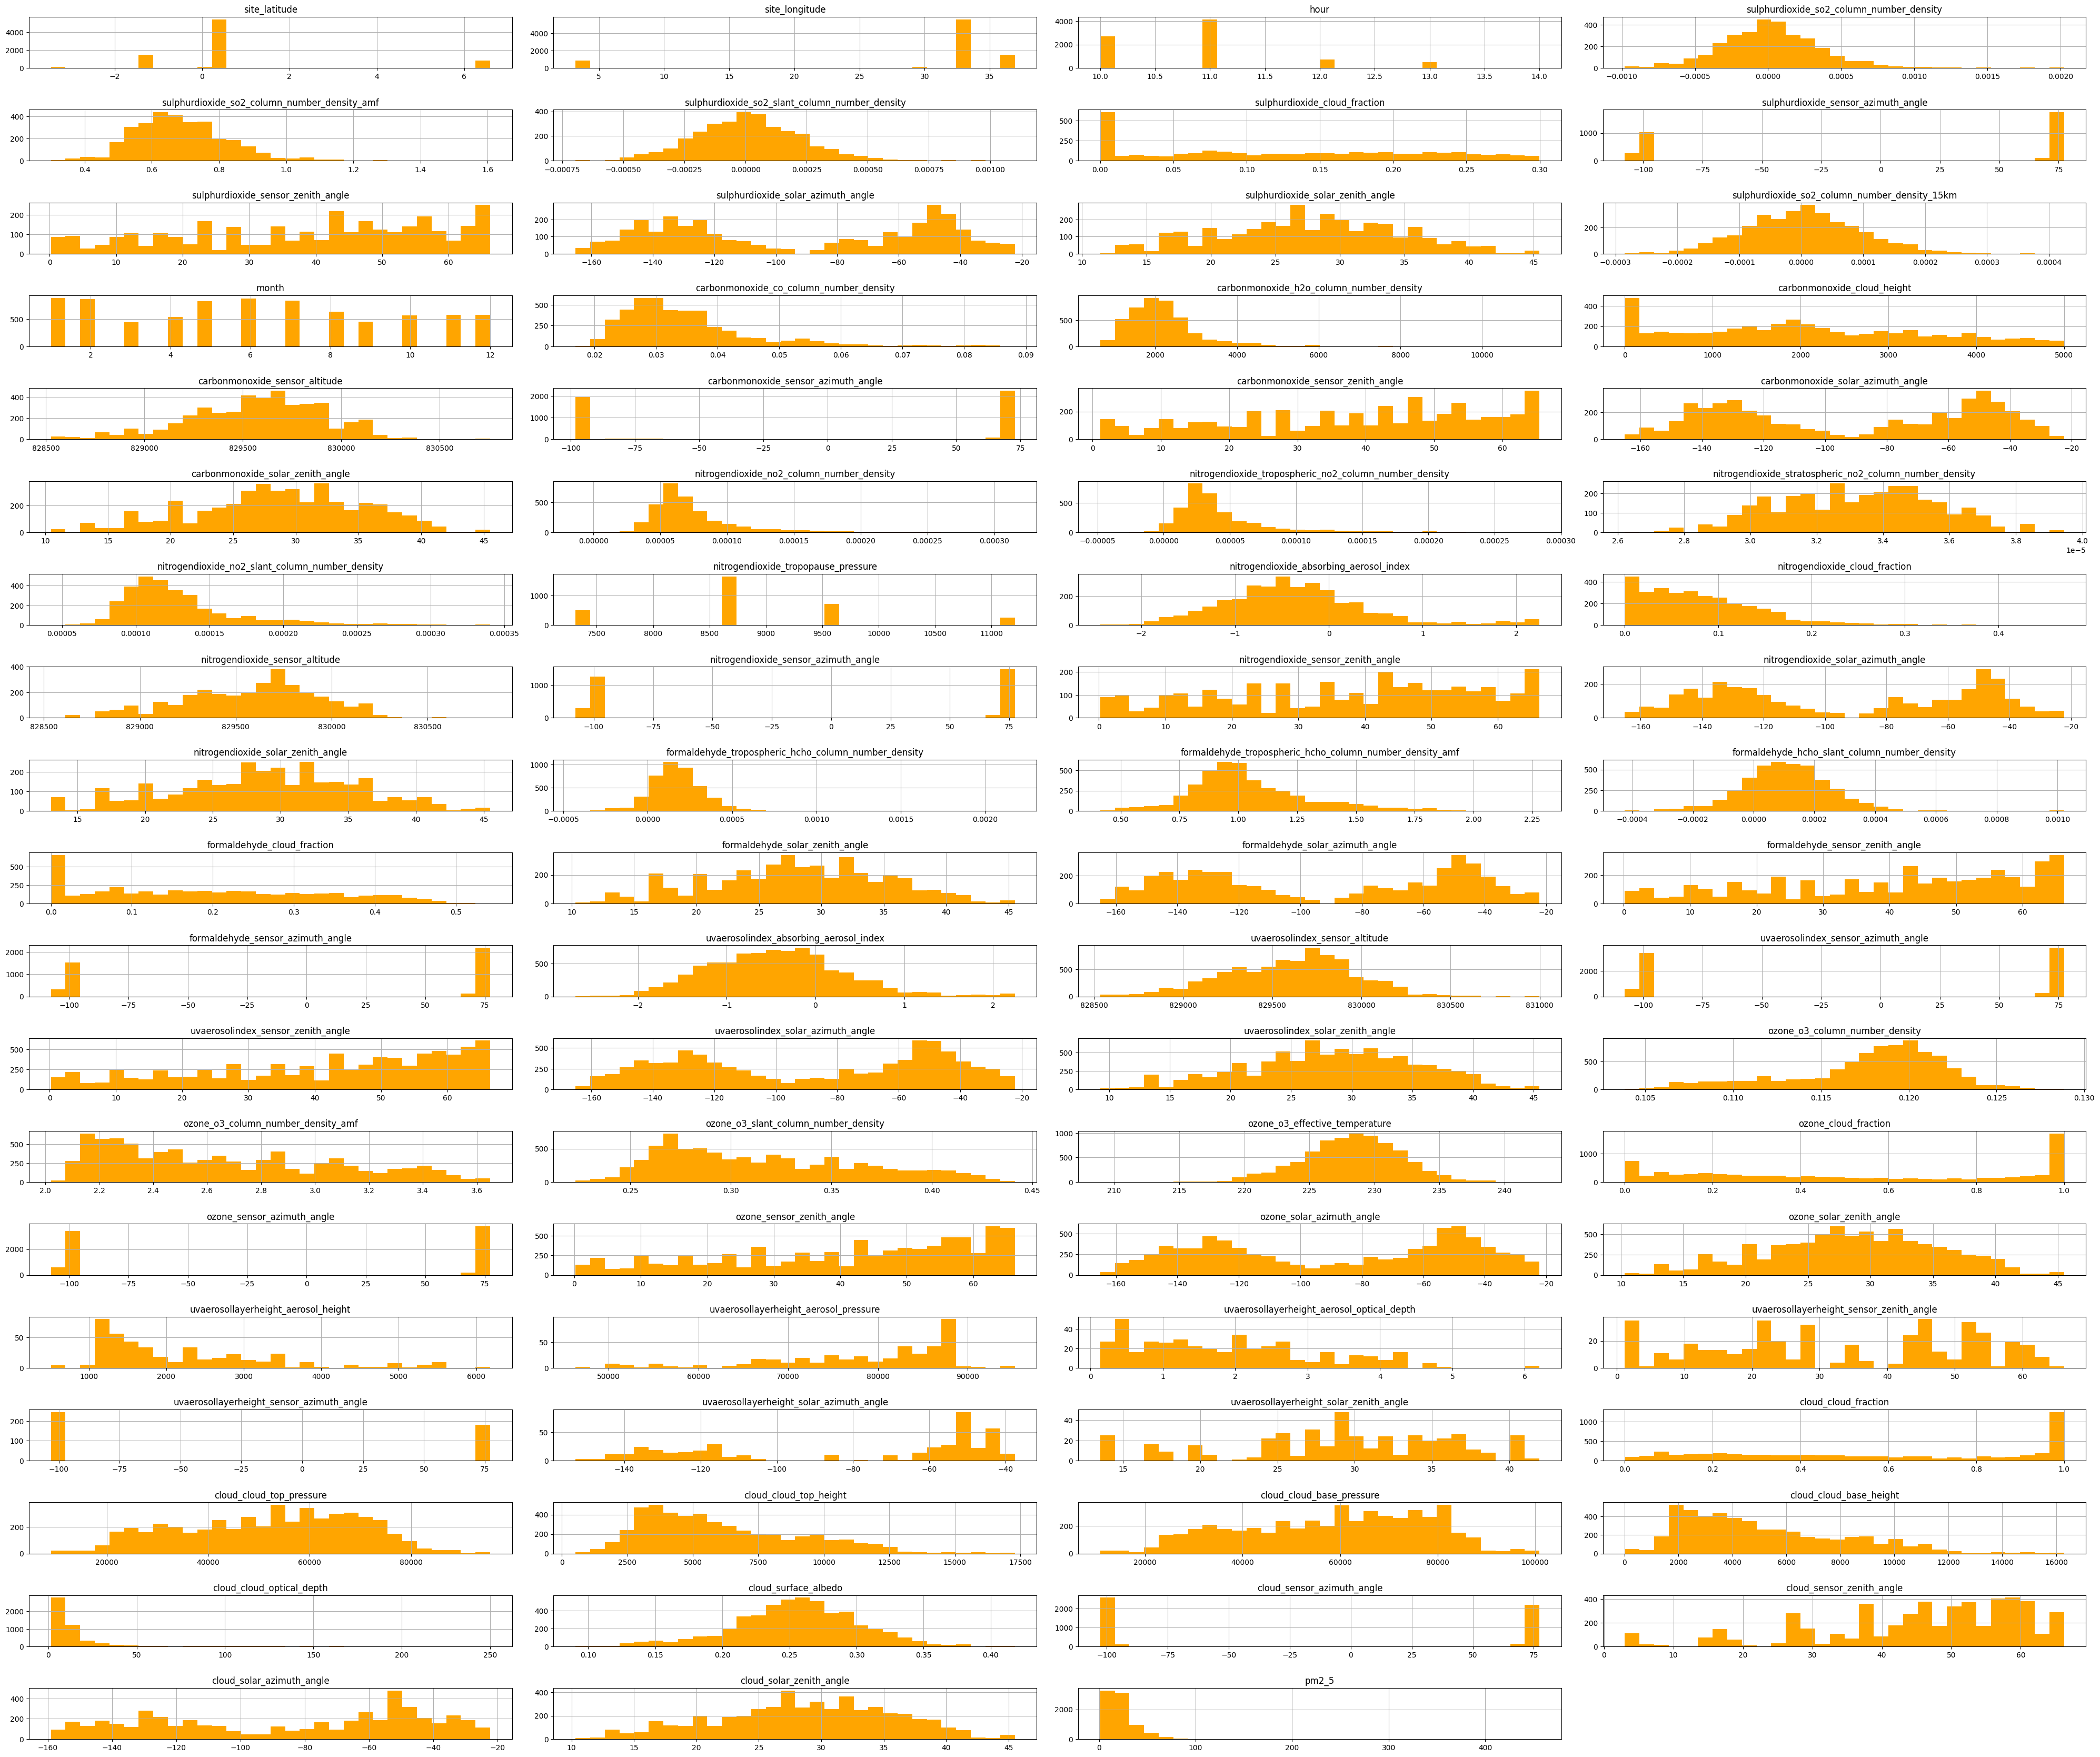

In [ ]:
# Plotting features distribution using histogram
plt.figure(figsize=(12, 8))
Air_qlt.hist(bins=30, figsize=(40, 35), layout=(20, 4), color ='orange')
plt.tight_layout()
plt.show()

• The histograms exhibit a wide range of distributions, including skewed, normal, and uniform shapes.

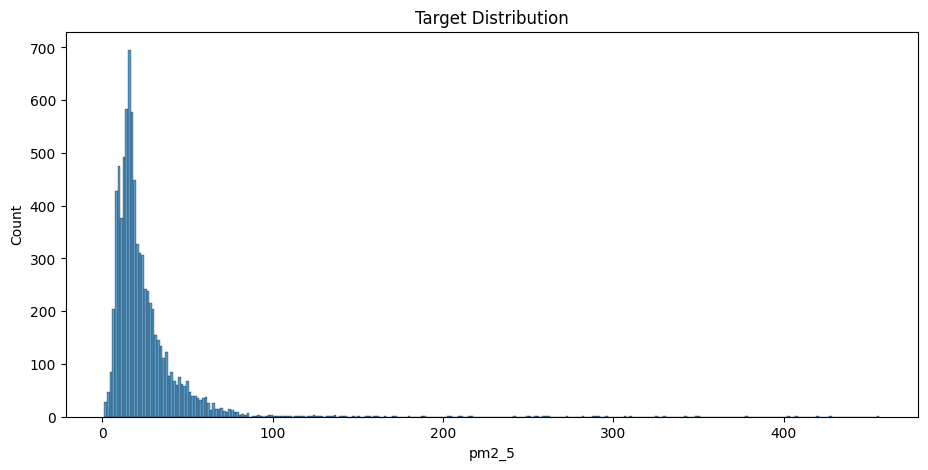

In [ ]:
# target distribution
plt.figure(figsize = (11, 5))
sns.histplot(Air_qlt.pm2_5)
plt.title('Target Distribution')
plt.show()

Target variable (pm2_5) has values skewed to the right.

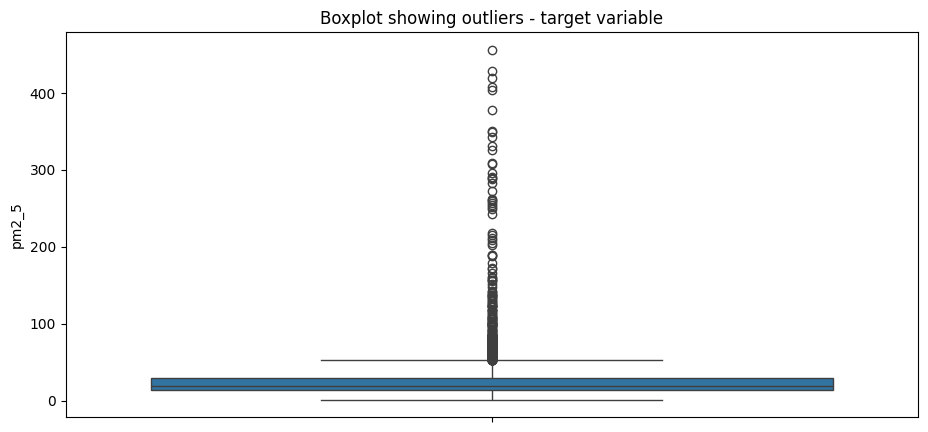

In [ ]:
# Check for outliers in the target variable
plt.figure(figsize = (11, 5))
sns.boxplot(Air_qlt.pm2_5)
plt.title('Boxplot showing outliers - target variable')
plt.show()

The target variable (pm2_5) has some outliers. Data transformation is required.

In [ ]:
 # Select only numerical features
Air_qlt_num = Air_qlt.select_dtypes(include=['number'])

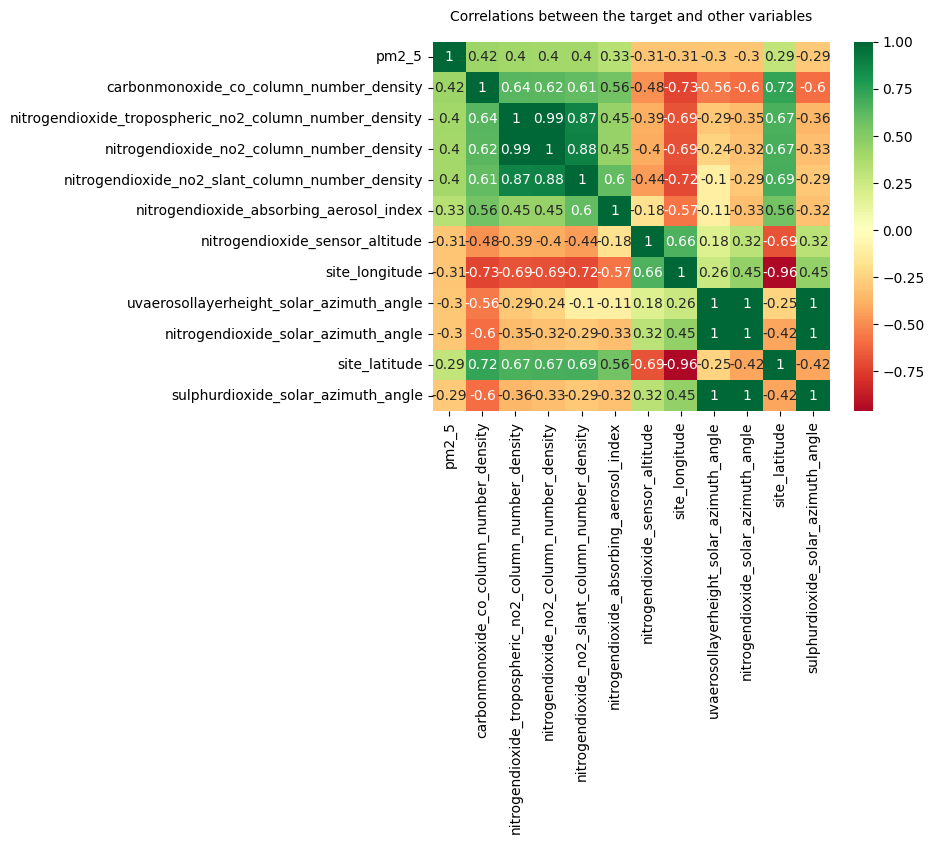

In [ ]:
# Correlations between the target and other variables
nAqt = abs(Air_qlt_num.corr()['pm2_5']).sort_values(ascending = False).head(12)
nAirqlt =  Air_qlt_num[list(nAqt.index)].corr()
sns.heatmap(nAirqlt, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlations between the target and other variables', pad = 15, fontdict={'size': 10})
plt.show()

• pm2_5 have both weak positive and negative association with other variables.

• Strong positive and negative association observed among other variables

<Figure size 1000x600 with 0 Axes>

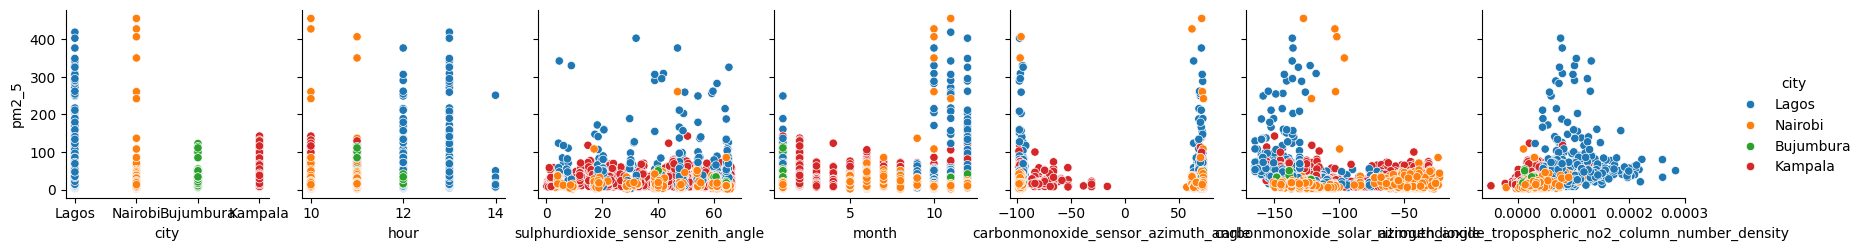

In [ ]:
# Relationship between the target and other selected variables
selected_col2 = ['city', 'hour', 'sulphurdioxide_sensor_zenith_angle',  'month',  'carbonmonoxide_sensor_azimuth_angle', 'carbonmonoxide_solar_azimuth_angle',  'nitrogendioxide_tropospheric_no2_column_number_density']

plt.figure(figsize=(10, 6))
sns.pairplot(Air_qlt, y_vars='pm2_5', x_vars=[col for col in Air_qlt[selected_col2].columns if col != 'pm2_5'], hue = 'city')
plt.show()

<Figure size 1000x600 with 0 Axes>

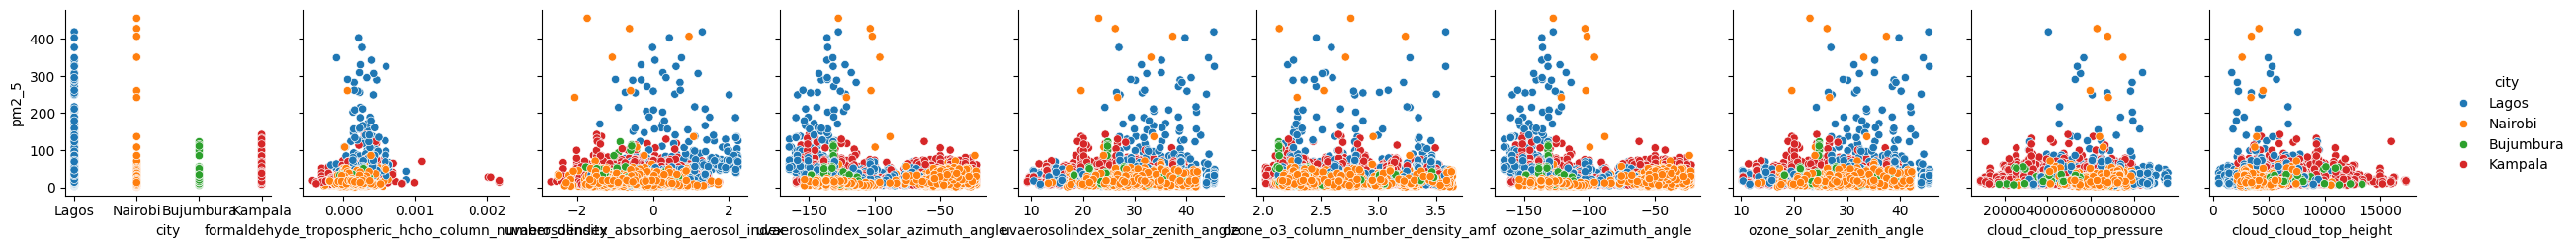

In [ ]:
# Relationship between the target and other selected variables
selected_col3 = ['city', 'formaldehyde_tropospheric_hcho_column_number_density',  'uvaerosolindex_absorbing_aerosol_index', 'uvaerosolindex_solar_azimuth_angle', 'uvaerosolindex_solar_zenith_angle', 'ozone_o3_column_number_density_amf', 'ozone_solar_azimuth_angle', 'ozone_solar_zenith_angle', 'cloud_cloud_top_pressure', 'cloud_cloud_top_height']

plt.figure(figsize=(10, 6))
sns.pairplot(Air_qlt, y_vars='pm2_5', x_vars=[col for col in Air_qlt[selected_col3].columns if col != 'pm2_5'], hue = 'city')
plt.show()

• There's significant variation in PM2.5 levels across the cities. Lagos and Nairobi appear to have higher overall PM2.5 concentrations compared to Bujumbura and Kampala.

• For Sulphur dioxide sensor zenith angle: A potential weak negative correlation in some cities, suggesting higher PM2.5 with lower zenith angles.

• For Nitrogen dioxide tropospheric column number density: A possible positive correlation, especially in Lagos and Nairobi, suggesting higher PM2.5 with increased nitrogen dioxide levels

DATA TRANSFORMATION

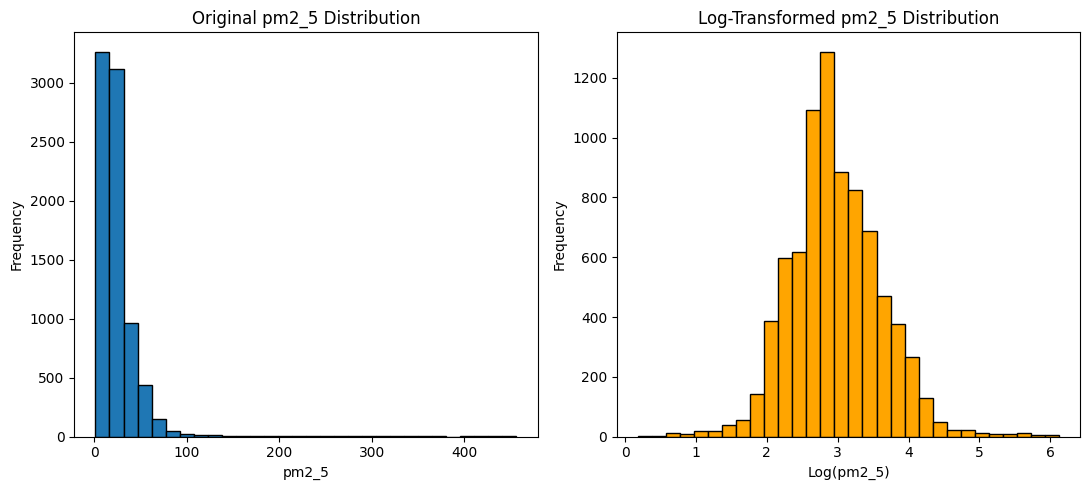

In [ ]:
# Apply log transformation of pm2_5 for Air_qlt1
Air_qlt1['pm2_5_log'] = np.log(Air_qlt1['pm2_5'])

# Histogram of the original pm2_5 data
plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.hist(Air_qlt1['pm2_5'], bins=30, edgecolor='black')
plt.title('Original pm2_5 Distribution')
plt.xlabel('pm2_5')
plt.ylabel('Frequency')

# Histogram of the log-transformed pm2_5 data
plt.subplot(1, 2, 2)
plt.hist(Air_qlt1['pm2_5_log'], bins=30, edgecolor='black', color ='orange')
plt.title('Log-Transformed pm2_5 Distribution')
plt.xlabel('Log(pm2_5)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

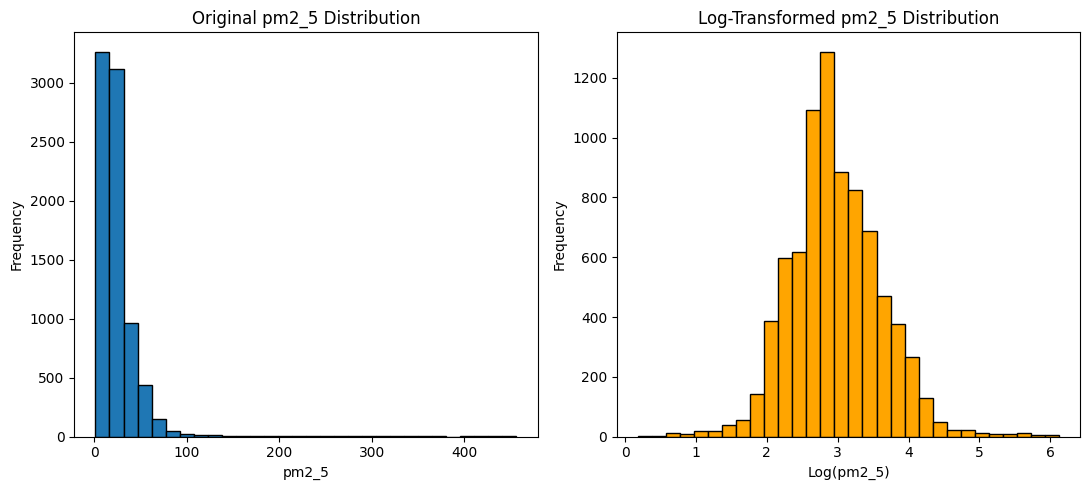

In [ ]:
# Apply log transformation of pm2_5 for Air_qlt2
Air_qlt2['pm2_5_log'] = np.log(Air_qlt2['pm2_5'])

# Histogram of the original pm2_5 data
plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.hist(Air_qlt2['pm2_5'], bins=30, edgecolor='black')
plt.title('Original pm2_5 Distribution')
plt.xlabel('pm2_5')
plt.ylabel('Frequency')

# Histogram of the log-transformed pm2_5 data
plt.subplot(1, 2, 2)
plt.hist(Air_qlt2['pm2_5_log'], bins=30, edgecolor='black', color ='orange')
plt.title('Log-Transformed pm2_5 Distribution')
plt.xlabel('Log(pm2_5)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

• The original distribution of PM2.5 is heavily right-skewed, indicating a long tail of high values. This is a common pattern in environmental data.

• The log transformation effectively reduces the skewness in the data, making the distribution more bell-shaped (closer to normal). This is often desirable for many statistical models.

• The log transformation compresses the larger values, bringing them closer to the mean. This can help improve the performance of models sensitive to outliers or skewed data.

In [ ]:
# Dropping columns
Air_qlt1.drop(['id', 'site_id','city', 'country', 'date', 'pm2_5'], axis=1, inplace=True)

In [ ]:
Air_qlt1.head()

,site_latitude,site_longitude,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5_log
0,6.53257,3.39936,13,0.000024,0.687295,0.000013,0.126581,2.120939,38.671939,-92.912582,27.700157,0.000004,10.0,0.034887,2200.218221,2041.463881,829573.191993,-8.063021,38.482742,-91.507702,28.609344,0.000074,0.000040,0.000033,0.000130,8836.367723,-0.369219,0.081754,829581.679425,-12.334603,37.299477,-93.711870,28.807872,0.000175,1.046935,0.000109,0.192196,28.036877,-92.363482,40.218543,-2.760999,0.052301,828817.9375,-100.805145,21.720518,-123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,-100.805145,21.720518,-123.523796,33.745914,0.580149,51850.474269,6089.449805,58478.947647,5105.978072,16.885186,0.255501,-18.952179,45.881380,-84.811978,28.708028,2.486156
1,6.53257,3.39936,12,0.000024,0.687295,0.000013,0.126581,2.120939,38.671939,-92.912582,27.700157,0.000004,11.0,0.045475,3771.027210,3399.756845,828569.623806,69.245351,59.159695,-143.370575,26.566997,0.000074,0.000040,0.000033,0.000130,8836.367723,-0.369219,0.081754,829581.679425,-12.334603,37.299477,-93.711870,28.807872,0.000214,1.462390,0.000240,0.359150,26.525513,-143.480164,59.220097,70.875954,-0.315206,828578.6250,70.875954,59.220097,-143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,-143.480164,26.525513,0.580149,51850.474269,6089.449805,58478.947647,5105.978072,16.885186,0.255501,-18.952179,45.881380,-84.811978,28.708028,3.744011
2,6.53257,3.39936,13,0.000024,0.687295,0.000013,0.126581,2.120939,38.671939,-92.912582,27.700157,0.000004,11.0,0.034887,2200.218221,2041.463881,829573.191993,-8.063021,38.482742,-91.507702,28.609344,0.000074,0.000040,0.000033,0.000130,8836.367723,-0.369219,0.081754,829581.679425,-12.334603,37.299477,-93.711870,28.807872,0.000175,1.046935,0.000109,0.192196,28.036877,-92.363482,40.218543,-2.760999,1.097816,828878

In [ ]:
# Dropping columns
Air_qlt2.drop(['id', 'site_id','city', 'country', 'date', 'pm2_5'], axis=1, inplace=True)

In [ ]:
Air_qlt2.head()

,site_latitude,site_longitude,hour,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5_log
0,6.53257,3.39936,13,10.0,0.034887,2200.218221,2041.463881,829573.191993,-8.063021,38.482742,-91.507702,28.609344,0.000175,1.046935,0.000109,0.192196,28.036877,-92.363482,40.218543,-2.760999,0.052301,828817.9375,-100.805145,21.720518,-123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,-100.805145,21.720518,-123.523796,33.745914,0.580149,51850.474269,6089.449805,58478.947647,5105.978072,16.885186,0.255501,-18.952179,45.881380,-84.811978,28.708028,2.486156
1,6.53257,3.39936,12,11.0,0.045475,3771.027210,3399.756845,828569.623806,69.245351,59.159695,-143.370575,26.566997,0.000214,1.462390,0.000240,0.359150,26.525513,-143.480164,59.220097,70.875954,-0.315206,828578.6250,70.875954,59.220097,-143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,-143.480164,26.525513,0.580149,51850.474269,6089.449805,58478.947647,5105.978072,16.885186,0.255501,-18.952179,45.881380,-84.811978,28.708028,3.744011
2,6.53257,3.39936,13,11.0,0.034887,2200.218221,2041.463881,829573.191993,-8.063021,38.482742,-91.507702,28.609344,0.000175,1.046935,0.000109,0.192196,28.036877,-92.363482,40.218543,-2.760999,1.097816,828878.6875,-96.411942,61.045010,-121.307121,41.898113,0.117559,3.248703,0.384168,224.102463,0.754163,-96.411942,61.045010,-121.307121,41.898113,0.756392,45185.499590,6791.682888,51171.802486,5791.682829,11.816715,0.192757,-96.411890,61.045123,-121.307414,41.898269,3.675053
3,6.53257,3.39936,14,11.0,0.034887,2200.218221,2041.463881,829573.191993,-8.063021,38.482742,-91.507702,28.609344,0.000175,1.046935,0.000109,0.192196,28.036877,-92.363482,40.218543,-2.760999,0.591543,828920.6875,-95.863083,65.508858,-122.218231,43.923038,0.118412,3.505708,0.416643,226.529633,1.000000,-95.863083,65.508858,-122.218231,43.923038,0.580149,51850.474269,6089.449805,58478.947647,5105.978072,16.885186,0.255501,-18.952179,45.881380,-84.811978,28.708028,2.354950
4,6.53257,3.39936,13,11.0,0.049045,3514.042054,1678.370478,828902.790450,-96.099639,49.432796,-126.070747,40.144183,0.000100,1.298433,0.000068,0.223403,40.167336,-126.064468,49.513344,-97.811241,0.069669,828919.0000,-97.811241,49.513344,-126.064468,40.167336,0.117899,2.796072,0.334256,226.368851,0.226150,-97.811241,49.513344,-126.064468,40.167336,0.226141,86197.531250,1451.050659,96215.906250,451.050598,10.521009,0.153114,-97.811241,49.513439,-126.064453,40.167355,2.966907


Key variables to consider including alongside pm2_5_log for model building:

• Carbon monoxide, nitrogen dioxide, sulphur dioxide, and ozone levels

• UV aerosol index and layer height

• Cloud fraction and height

• Geographical factors (longitude, latitude)

• Temporal factors (month)

MODEL TRAINING AND EVALUATION

Splitting into train and test data

In [ ]:
# Select X and y features for modelling
x1 = Air_qlt1.drop('pm2_5_log', axis = 1)
y1 = Air_qlt1.pm2_5_log

In [ ]:
x1_train, x1_test, y1_train, y1_test = (train_test_split(x1,y1, test_size = 0.3, random_state = 42))
x1_train.shape
x1_test.shape

print('x1 train shape', x1_train.shape)
print('x1 test shape', x1_test.shape)

x1 train shape (5649, 67)
x1 test shape (2422, 67)


In [ ]:
# Select X and y features for modelling
x2 = Air_qlt2.drop('pm2_5_log', axis = 1)
y2 = Air_qlt2.pm2_5_log

In [ ]:
x2_train, x2_test, y2_train, y2_test = (train_test_split(x2,y2, test_size = 0.3, random_state = 42))
x2_train.shape
x2_test.shape

print('x2 train shape', x2_train.shape)
print('x2 test shape', x2_test.shape)

x2 train shape (5649, 46)
x2 test shape (2422, 46)


In [ ]:
scaler = StandardScaler()
x1 = scaler.fit_transform(x1)
x2 = scaler.fit_transform(x2)

• Standardization of dataset because it is more robust to different distributions and less sensitive to outliers

• Standardization to ensure better model performance

Light Gradient Boost Model -
Test and train data (x1 and y1)

In [ ]:
LGBM1 = LGBMRegressor()
LGBM1.fit(x1_train, y1_train)

y1_pred = LGBM1.predict(x1_test)

LGBM1_score = mean_squared_error(y1_test, y1_pred, squared=False)
LGBM1_mae = mean_absolute_error(y1_test, y1_pred)
LGBM1_r2= r2_score(y1_test, y1_pred)

print('Local RMSE:', LGBM1_score)
print('Local MAE:', LGBM1_mae)
print('Local R-squared:', LGBM1_r2)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16223
[LightGBM] [Info] Number of data points in the train set: 5649, number of used features: 67
[LightGBM] [Info] Start training from score 2.966775
Local RMSE: 0.3478497379628386
Local MAE: 0.24050128990859415
Local R-squared: 0.6945711472193665


In [ ]:
# Convert back to original scale
y1_test_original = np.exp(y1_test)
y1_pred_original = np.exp(y1_pred)

# Create DataFrame
y1Predict = pd.DataFrame({"Actual": y1_test_original, "Predicted": y1_pred_original})
y1Predict.head()

,Actual,Predicted
742,18.009200,20.674123
2127,28.199700,25.169658
2107,19.466667,15.243283
2943,47.629700,50.926600
6691,41.196300,39.156827


Light Gradient Boost Model -
Test and train data (x2 and y2)

In [ ]:
LGBM2 = LGBMRegressor()
LGBM2.fit(x2_train, y2_train)

y2_pred = LGBM2.predict(x2_test)

LGBM2_score = mean_squared_error(y2_test, y2_pred, squared=False)
LGBM2_mae = mean_absolute_error(y2_test, y2_pred)
LGBM2_r2= r2_score(y2_test, y2_pred)

print('Local RMSE:', LGBM2_score)
print('Local MAE:', LGBM2_mae)
print('Local R-squared:', LGBM2_r2)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10868
[LightGBM] [Info] Number of data points in the train set: 5649, number of used features: 46
[LightGBM] [Info] Start training from score 2.966775
Local RMSE: 0.34265949605616375
Local MAE: 0.2373739664155015
Local R-squared: 0.7036177139370208


In [ ]:
# Convert back to original scale
y2_test_original = np.exp(y2_test)
y2_pred_original = np.exp(y2_pred)

# Create DataFrame
y2Predict = pd.DataFrame({"Actual": y2_test_original, "Predicted": y2_pred_original})
y2Predict.head()

,Actual,Predicted
742,18.009200,21.782371
2127,28.199700,25.754912
2107,19.466667,15.913549
2943,47.629700,52.501152
6691,41.196300,44.100737


Random Forest Regressor-
Test and train data (x1 and y1)

In [ ]:
RFR1 = RandomForestRegressor()
RFR1.fit(x1_train, y1_train)

y1_pred = RFR1.predict(x1_test)

RFR1_score = mean_squared_error(y1_test, y1_pred, squared=False)
RFR1_mae = mean_absolute_error(y1_test, y1_pred)
RFR1_r2= r2_score(y1_test, y1_pred)

print('Local RMSE:', RFR1_score)
print('Local MAE:', RFR1_mae)
print('Local R-squared:', RFR1_r2)

Local RMSE: 0.38267975647796953
Local MAE: 0.2569106204011341
Local R-squared: 0.6303440698535643


In [ ]:
# Convert back to original scale
y1_test_original = np.exp(y1_test)
y1_pred_original = np.exp(y1_pred)

# Create DataFrame
y1Predict = pd.DataFrame({"Actual": y1_test_original, "Predicted": y1_pred_original})
y1Predict.head()

,Actual,Predicted
742,18.009200,20.581379
2127,28.199700,23.671347
2107,19.466667,18.196869
2943,47.629700,50.376817
6691,41.196300,30.524141


Random Forest Regressor-
Test and train data (x2 and y2)

In [ ]:
RFR2 = RandomForestRegressor()
RFR2.fit(x2_train, y2_train)

y2_pred = RFR2.predict(x2_test)

RFR2_score = mean_squared_error(y2_test, y2_pred, squared=False)
RFR2_mae = mean_absolute_error(y2_test, y2_pred)
RFR2_r2= r2_score(y2_test, y2_pred)

print('Local RMSE:', RFR2_score)
print('Local MAE:', RFR2_mae)
print('Local R-squared:', RFR2_r2)

Local RMSE: 0.3751721482918112
Local MAE: 0.2541770240920235
Local R-squared: 0.6447059945584902


In [ ]:
# Convert back to original scale
y2_test_original = np.exp(y2_test)
y2_pred_original = np.exp(y2_pred)

# Create DataFrame
y2Predict = pd.DataFrame({"Actual": y2_test_original, "Predicted": y2_pred_original})
y2Predict.head()

,Actual,Predicted
742,18.009200,21.079308
2127,28.199700,22.981683
2107,19.466667,19.160245
2943,47.629700,50.085507
6691,41.196300,34.038139


Comparing different model rmse

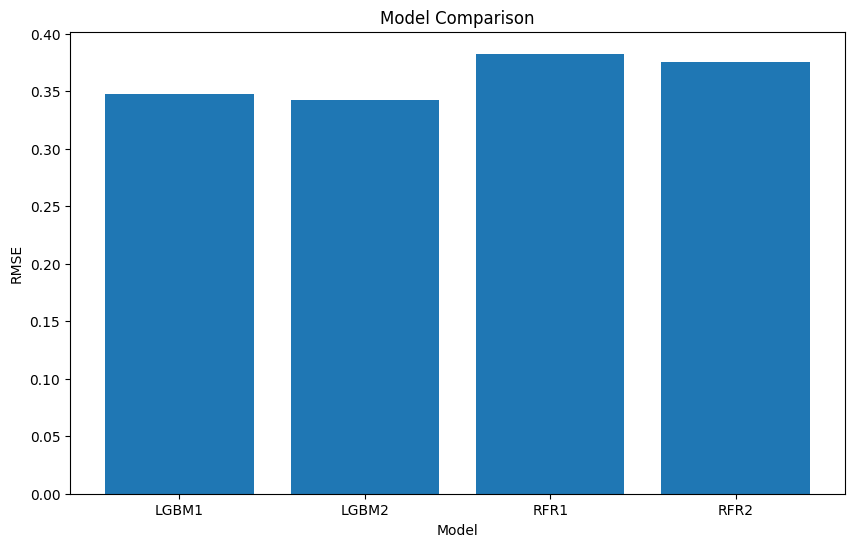

In [ ]:
# RMSE scores for LGBM1, LGBM2, RFR1 and RFR2
results = {'LGBM1': 0.34784, 'LGBM2': 0.34265, 'RFR1': 0.38268, 'RFR2': 0.37517}

plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Model Comparison')
plt.show()

• LGBM2 exhibits the lowest RMSE and MAE, highest R-squared value among the compared models. This indicates that the LGBM2 model generally makes predictions closer to the actual values compared to the other models. LGBM2 explains the most variance in the data, followed by LGBM1, RFR2, and RFR1. This suggests that LGBM2 captures the underlying patterns in the data more effectively.

• LGBM1 also performs well, closely following LGBM2.

• RFR1 and RFR2 show similar performance, with slightly higher error metrics (RMSE and MAE) and lower R-squared compared to the LGBM models.

• LGBM2 is the best-performing model among the compared options. LGBM2 used data from Air_qlt2 which contained dataset with maximum of 50% missing values.


CONCLUSION

Light Gradient Boost Model was able to predict air quality around Africa using Sentinel 5P satellite data. It had the lowest RMSE and MAE, highest R-squared value compared to Random Forest Regressor. This indicates that the LGBM model made predictions closer to the actual values as it captured the underlying patterns in the data more effectively.